<a href="https://colab.research.google.com/github/akalgreadis/deep-learning-playground/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning Sentiment Analysis

In this hands-on exercise we are going to learn to use Recurrent Neural Network (RNN) to perform sentiment analysis on movie reviews. 

The tools we are going to use for this exercise are :

* **Tensorflow** - an open-source software library for dataflow programming across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks.


* **Keras** - a heavyweight wrapper for Tensorflow. It’s minimalistic, modular, and awesome for rapid experimentation. This is our favorite Python library for deep learning and the best place to start for beginners.


* **Google CoLab** - an implementation of the widely used open-source Jupyter Notebook that has most popular libraries used for machine learning already preinstalled. Its a perfect tool for rapid prototyping and experimentation.


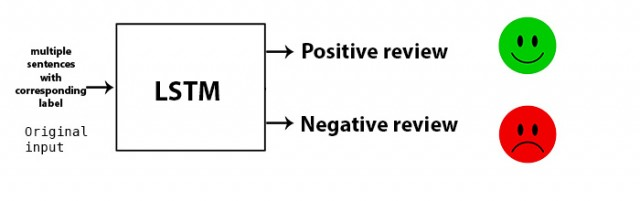

In [1]:
from IPython.display import Image
Image('https://preview.ibb.co/bC0Kfq/sentiment-Analysis-Workshop.jpg')

# Step 1 - Import libraries and modules

In [0]:
import pandas as pd
import numpy 
import keras
# Import the sequential model, which is a linear stack of layers
from keras.models import Sequential 
# Import the core layers that are used in almost any neural netwrok
from keras.layers import Dense, Dropout, Flatten
# Import the LSTM layer which is commonly used in RNN's
from keras.layers import LSTM 
from keras.layers.embeddings import Embedding 
from keras.callbacks import TensorBoard
from numpy import array

#Step 2 - Import the IMDb dataset 

As a first step, we will load the Internet Movie Database (IMDB) dataset, which is already part of the Keras datasets.

The dataset consists of 25,000 movies reviews from IMDb, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

In [0]:
from keras.datasets import imdb 
# Define the n most common words we want to load
top_words = 5000
# Load the train and test datasets
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_words)

# Step 3 - Preprocess input data

## Print movie review example 

Let's print an example of a movie review from the dataset.

We only loaded the 5000 most common words from the dataset, therefore some words migh appear as < UNKNOWN >.

In [0]:
# Load the word indices such that we can convert the integers representations of the words in the dataset to strings
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+3) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNKOWN>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}

# Define the review to print, try changing this number to see the print for different reviews
review_number = 0
# Print the review text
print(' '.join(id_to_word[id] for id in x_train[review_number] ))
# Print the sentiment of the review, 0 represents a negative review, 1 represents a positive review
print('sentiment = ', y_train[review_number] )

## Preprocess data
Not all reviews contain the same number of words, we will truncate the reviews in both the training and test datasets to a maximum number of words of 500.

In [0]:
# Truncate and pad the review sequences
from keras.preprocessing import sequence 
max_review_length = 500 
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length) 
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length) 

# Print the shape of the datasets, which should have a size of: 
# total number of reviews X number of words in the reviews
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

##Print data sample

If you run the cell below, we will print the first reviews.

If you look at the data you will realize it has been already pre-processed. All words have been mapped to integers and the integers represent the words sorted by their frequency. It is very common in text analysis to represent a dataset like this. So 4 represents the 4th most used word, 5 the 5th most used word and so on

In [0]:
# Print the first reviews.
pd.DataFrame(x_train).head()

# Step 4 - Design model architecture

The next step is to create the model that will be trained. We will use the Keras Sequential model, which is a linear stack of layers. For more information see https://keras.io/getting-started/sequential-model-guide/.

* The first layer is an embedding layer. https://keras.io/layers/embeddings/

* The second layer is a Long Short Term Memory (LSTM) layer, which is a type of recurrent layer. 

* The third layer is a fully connected layer.

The last step is to compile the model, for which we need to select both a loss function and an optimizer. Keras offer a wide selection and you can find more information here: 

* Loss functions : https://keras.io/losses/
* Optimizers: https://keras.io/optimizers/


In [0]:
embedding_vector_length = 32  #@param {type:"slider", min:16, max:64, step:16}
number_recurrents = 4  #@param {type:"slider", min:2, max:10, step:1}

# Create the model and add layers
model = Sequential() 
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length)) 
model.add(LSTM(number_recurrents))
model.add(Dense(1, activation='sigmoid')) 
# Compile the model with the selected loss function and optimizer
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 
print(model.summary())

# Step 5 - Train the model

Before we are ready to fit our model we need to select two more parameters, batch size and number of epochs.

* **Batch size** : defines the number of samples that will be propagated through the network. Advantages of using a batch size smaller that your total samples is memory usage and efficiency in training.

* **Epochs** : The number of epochs is the number of times the model will cycle through the data. The more epochs we run, the more the model will improve, up to a certain point. After that point, the model will stop improving during each epoch.

We will then fit the model which we defined in the previous step. This should take a little over 2 minutes per epoch. Notice that the training loss decreases and the accuracy increases over time.

In [0]:
#@title Define model parameter values
batch_size = 64 #@param {type:"slider", min:0, max:128, step:32}
epochs = 3 #@param {type: "slider", min: 1, max: 8}

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint(filepath="best_weights.hdf5", monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [early_stopping, checkpoint]

convergence_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

#Step 6 - Validation

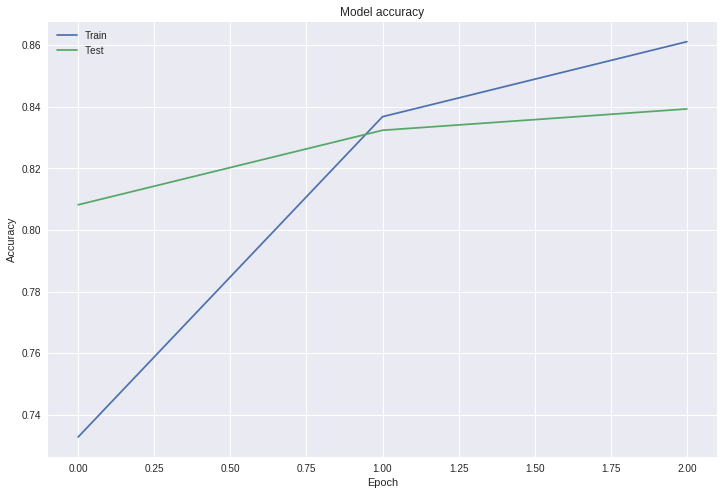

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12,8))
plt.plot(convergence_history.history['acc'])
plt.plot(convergence_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

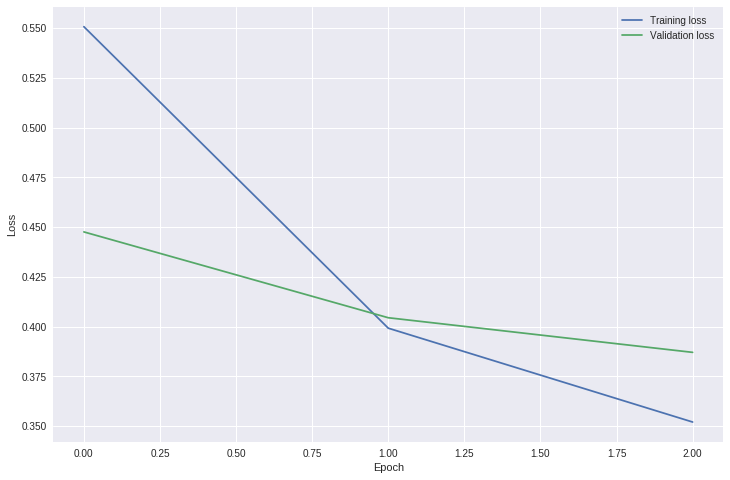

In [27]:
# Plot training & validation loss values
plt.figure(figsize=(12,8))
plt.plot(convergence_history.history['loss'], label="Training loss")
plt.plot(convergence_history.history['val_loss'], label="Validation loss")
plt.grid("on")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Step 7 - Evaluate the model

Use the test data to calculate the accuracy of the trained model.

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1) 
print("Accuracy: %.2f%%" % (scores[1]*100))

# Step 8 - Use the trained model
Predict sentiment from the reviews:

"this movie was terrible and bad"
"i really liked the movie and had fun"

In [0]:
bad = "this movie was terrible and bad"
good = "i really liked the movie and had fun"
for review in [good,bad]:
    tmp = []
    for word in review.split(" "):
        tmp.append(word_to_id[word])
    tmp_padded = sequence.pad_sequences([tmp], maxlen=max_review_length) 
    print("%s. Sentiment: %s" % (review,model.predict(array([tmp_padded][0]))[0][0]))

Now predict your own sentences with the trained model

In [0]:
import string
#@title Define your review and predict the sentiment
badReview = "" #@param {type:"string"}
goodReview = "" #@param {type:"string"}

if badReview == "" or goodReview == "":
  print("Please provide a good and a bad review.")
else :
  exclude = set(string.punctuation)
  for review in [badReview,goodReview]:
      review = ''.join(ch for ch in review.lower() if ch not in exclude)
      tmp = []
      for word in review.split(" "):
        if word in word_to_id:
          if word_to_id[word] < top_words:
            tmp.append(word_to_id[word])
      tmp_padded = sequence.pad_sequences([tmp], maxlen=max_review_length) 
      print("%s. Sentiment: %s" % (review, model.predict(array([tmp_padded][0]))[0][0]))